In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.image import resize
import tensorflow

In [2]:
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  4


## Load and Pre-process data

### load from pickle

In [3]:
#full_data = pd.read_pickle('dataset_df.pickle')
full_data = pd.read_pickle('dataset_df_120x187.pickle')
#del full_data

In [4]:
full_data.head(2)

,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,image_data
0,ISIC_2637011,IP_7279968,IL_7972535,male,45.0,head/neck,unknown,benign,0,"[[[160, 144, 185], [146, 132, 171], [82, 94, 1..."
1,ISIC_0015719,IP_3075186,IL_4649854,female,45.0,upper extremity,unknown,benign,0,"[[[65, 98, 156], [73, 98, 154], [74, 99, 161],..."


### Calculate initial weights

In [5]:
malignant_df = full_data.loc[full_data['benign_malignant'] == 'malignant', :]
benign_df = full_data.loc[full_data['benign_malignant'] == 'benign', :]

print(f"Total malignant entries: {str(malignant_df.shape[0])}")
print(f"Total benign entries: {str(benign_df.shape[0])}")

sample_malignant_df_df = benign_df.sample(n=malignant_df.shape[0] * 5)
dataset_df = malignant_df.append(sample_malignant_df_df)
#dataset_df = malignant_df.append(malignant_df)


malignant_total = dataset_df.loc[dataset_df['benign_malignant'] == 'malignant', 'benign_malignant'].count()
benign_total = dataset_df.loc[dataset_df['benign_malignant'] == 'benign', 'benign_malignant'].count()
print(f"Total {malignant_total + benign_total} | malignant (1) {malignant_total} | benign (0) {benign_total}")

weight_for_0 = (1 / benign_total) * ((malignant_total + benign_total) / 2.0)
weight_for_1 = (1 / malignant_total) * ((malignant_total + benign_total) / 2.0)
class_weights = {
    #benign
    0: weight_for_0,

    #malignant
    1: weight_for_1
}
print(class_weights)

Total malignant entries: 581
Total benign entries: 32120
Total 3486 | malignant (1) 581 | benign (0) 2905
{0: 0.6000000000000001, 1: 3.0}


### set X and y

In [6]:
# set y
y = np.array(dataset_df['benign_malignant'])

In [7]:
# set X
X = np.array([entry for entry in dataset_df['image_data']])

In [8]:
X.size

234677520

malignant
(120, 187, 3)


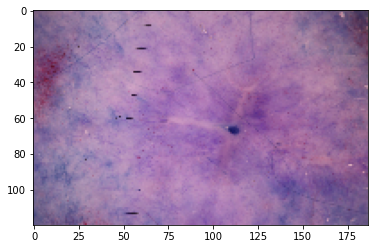

In [9]:
print(y[11])
plt.imshow(X[11])
print(X[11].shape)

In [10]:
#tmp = np.array([entry for entry in X_train])
#tmp.reshape(24525, -1).shape

### Split data into training and test sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1000, stratify=y)

In [12]:
print(X_train[0].shape)
print(X_train.shape)

(120, 187, 3)
(2614, 120, 187, 3)


In [13]:
np.unique(y_train, return_counts=True)

(array(['benign', 'malignant'], dtype=object), array([2178,  436]))

In [14]:
train_label_encoder = LabelEncoder()
train_label_encoder.fit(y_train)
y_train_encoded = train_label_encoder.transform(y_train)

test_label_encoder = LabelEncoder()
test_label_encoder.fit(y_test)
y_test_encoded = test_label_encoder.transform(y_test)

## One hot encoding

In [15]:
num_classes = 2
y_train_hencoded = to_categorical(y_train_encoded, num_classes)
y_test_hencoded = to_categorical(y_test_encoded, num_classes)

In [16]:
print(y_train_hencoded.shape)
print(y_test_hencoded.shape)

(2614, 2)
(872, 2)


## Build CNN model

In [17]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.math import argmax
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

### Standarize the data

In [18]:
print(X_train.shape)
#X_train.map(lambda x, y: ())
#X_train_norm = normalization_layer(X_train)

(2614, 120, 187, 3)


In [19]:
def create_model():
    model = Sequential([
        # scale
        Rescaling(1./255),

        #data augmentation
        #RandomFlip("horizontal_and_vertical"),
        #RandomRotation(0.5),

        Conv2D(X_train.shape[0], X_train.shape[-1], activation='relu', input_shape=(120, 187, 3)),
        MaxPooling2D(),
        #Dropout(0.3),
        
        Conv2D(X_train.shape[0], X_train.shape[-1], activation='relu'),
        MaxPooling2D(),

        Flatten(),
        Dense(units=len(train_label_encoder.classes_), activation='softmax')
    ])
    return model

In [20]:
# Compile the model
strategy = tensorflow.distribute.MirroredStrategy()
with strategy.scope():
    model = create_model()
    model.compile(optimizer=Adam(),# lr=0.01
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [21]:
print(X_train.shape[-1])
print(y_train.shape[0])

3
2614


In [22]:
# Fit the model to the training data
history = model.fit(
    X_train,
    y_train_hencoded,
    class_weight=class_weights,
    epochs=10,
    validation_split=0.1,
    shuffle=True,
    verbose=2
)

Epoch 1/10
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 6 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localh

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 120, 187, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 118, 185, 2614)    73192     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 92, 2614)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 90, 2614)      61499578  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 45, 2614)      0         
_________________________________________________________________
flatten (Flatten)            (None, 3293640)           0         
_________________________________________________________________
dense (Dense)                (None, 2)                 6

## Model Performance

In [24]:
# Evaluate the model using the training data
model_loss, model_accuracy = model.evaluate(X_test, y_test_hencoded, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

28/28 - 28s - loss: 0.6218 - accuracy: 0.7053
Loss: 0.6217634677886963, Accuracy: 0.7052752375602722


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


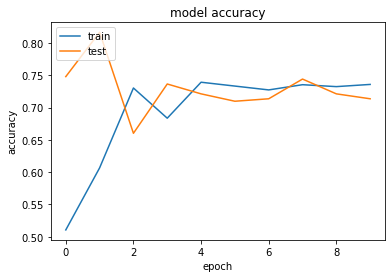

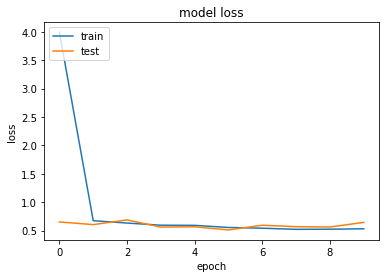

In [25]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Validation

In [26]:
import os
def validate(model, img_name):
    img = cv.imread(os.path.join('.', 'validation', img_name))
    # (240, 320, 3)
    #dim = (320, 240)
    width = X_train.shape[2]
    height = X_train.shape[1]
    dim = (width, height)
    new_img = cv.resize(img, dim)

    plt.imshow(new_img)

    x_prime = new_img.reshape((1, height, width, 3))
    x_prime.shape
    prediction = model.predict(x_prime)
    print(prediction[0])
    print( test_label_encoder.inverse_transform( argmax(prediction, axis=1) ) )

[0.10480317 0.8951968 ]
['malignant']


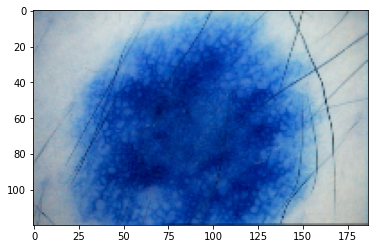

In [27]:
validate(model, 'ISIC_0362853-b.jpg')

[0.5920454  0.40795457]
['benign']


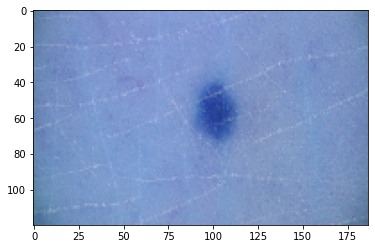

In [28]:
validate(model, 'ISIC_0463621-b.jpg')

[0.5513028 0.4486972]
['benign']


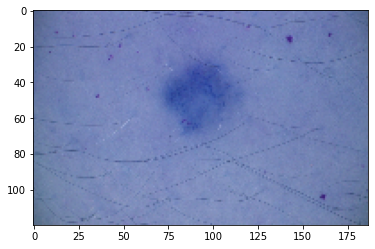

In [29]:
validate(model, 'ISIC_0584566-b.jpg')

[0.32056564 0.67943436]
['malignant']


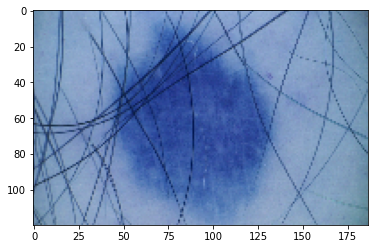

In [30]:
validate(model, 'ISIC_0615970-b.jpg')

[0.5120159 0.4879841]
['benign']


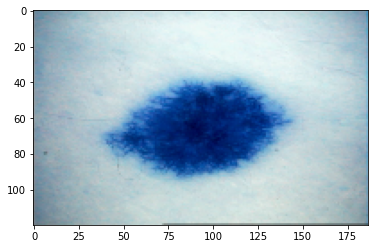

In [31]:
validate(model, 'ISIC_0626118-b.jpg')

[0.38820642 0.6117936 ]
['malignant']


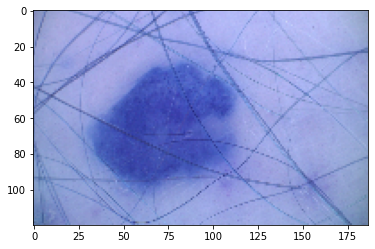

In [32]:
validate(model, 'ISIC_0793501-b.jpg')

[4.8941007e-04 9.9951065e-01]
['malignant']


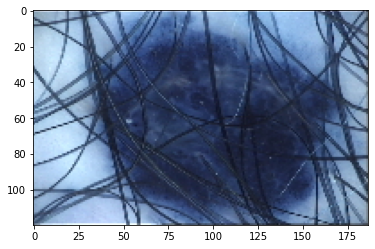

In [33]:
validate(model, 'ISIC_4012047-m.jpg')

[0.5019403  0.49805966]
['benign']


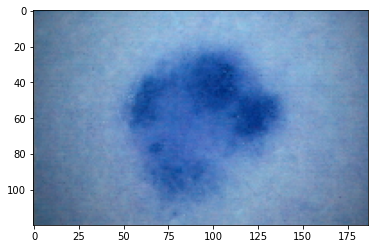

In [34]:
validate(model, 'ISIC_4619903-m.jpg')

[0.48498484 0.5150151 ]
['malignant']


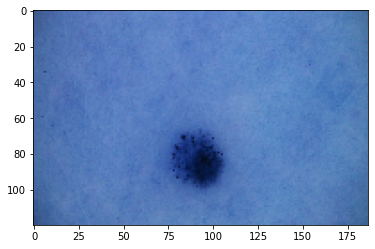

In [35]:
validate(model, 'ISIC_8066110-m.jpg')

[0.46217164 0.5378284 ]
['malignant']


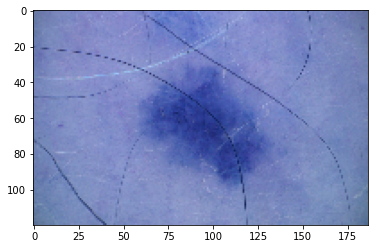

In [36]:
validate(model, 'ISIC_9870885-m.jpg')

In [37]:
# Save the model
model.save("em_model-rgb-adam-weighted.h5")